## Serial test

Idea: break the sequence $x_1, x_2, x_3, ..., x_{2n}$ into consecutive series of length $2$: $(x_1, x_2), (x_3, x_4), ..., (x_{2n-1}, x_{2n})$ and look at each element as a random and independent point in $2D$ space. Next, apply chi-square. Similarly, one can construct series of length $3, 4$, etc.

### Problem 1
Implement serial test and apply to a `samples`

In [24]:
import numpy as np
import scipy.stats as stats


def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

rng.current = 1

samples = [rng() for _ in range(10000)]


def serial_test(samples, length=2, k=5):
    tuples = np.array([samples[i:i + length] for i in range(0, len(samples) - length + 1, length)])

    edges = [np.linspace(0, 1, k + 1)] * length
    hist, _ = np.histogramdd(tuples, bins=edges)

    obs = hist.flatten()
    exp = np.full_like(obs, len(tuples) / (k ** length))

    _, p_value = stats.chisquare(obs, exp) 

    return p_value

p_val = serial_test(samples, length=2, k=5)
print("P_value =", p_val)

p_val = serial_test(samples, length=2, k=25)
print("P_value =", p_val)

p_val = serial_test(samples, length=3, k=20)
print("P_value =", p_val)




P_value = 0.8408841303102861
P_value = 0.9902201550113828
P_value = 0.9930403504104895


### Permutation test

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.

### Problem 2*
Implement permutation test and apply to a `samples`

In [25]:
from itertools import permutations


def permutation_test(samples, d=3):
    subs = [tuple(samples[i:i + d]) for i in range(0, len(samples) - d + 1, d)]
    
    all_perms = list(permutations(sorted(range(d))))   
    ranked_subs = [tuple(np.argsort(seq)) for seq in subs]

    obs_counts = np.array([ranked_subs.count(p) for p in all_perms])
    exp_counts = np.full_like(obs_counts, len(subs) / len(all_perms), dtype=float)

    _, p_value = stats.chisquare(obs_counts, exp_counts)

    return p_value


p_val = permutation_test(samples, d=3)
print("P_value =", p_val)

p_val = permutation_test(samples, d=4)
print("P_value =", p_val)

p_val = permutation_test(samples, d=5)
print("P_value =", p_val)



P_value = 0.39177317200448364
P_value = 0.36168555915127365
P_value = 0.7115771529627803


### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

Rng_good: P_value = 0.98256
Rng_bad: P_value = 0.45481


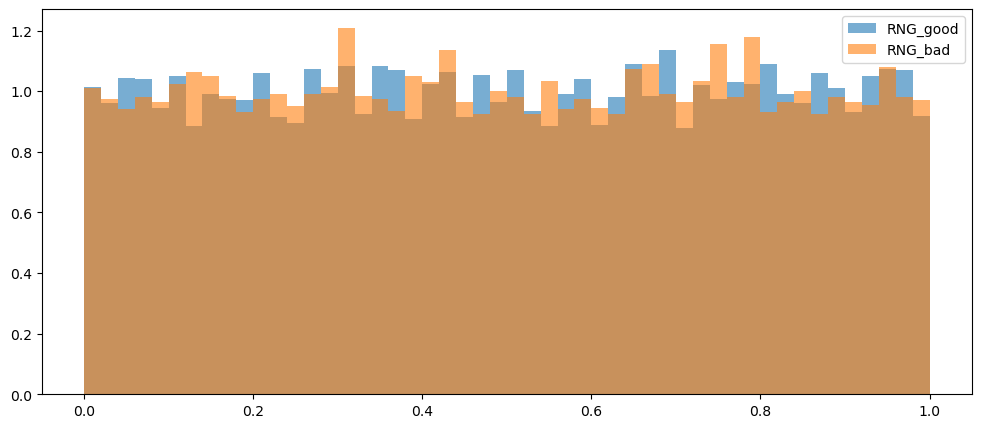

In [ ]:
import matplotlib.pyplot as plt


def rng_good(m=2**32, a=1103515245, c=12345):
    rng_good.current = (a * rng_good.current + c) % m
    return rng_good.current / m

rng_good.current = 1
good_sample = [rng_good() for _ in range(10000)]


def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m

rng_bad.current = 1
bad_sample = [rng_bad() for _ in range(10000)]


def test_rng(sample):
    obs_counts, _ = np.histogram(sample, bins=10, range=(0, 1))
    exp_counts = np.full_like(obs_counts, len(sample) / 10)
    _, p_value = stats.chisquare(obs_counts, exp_counts)
    return p_value

p_good = test_rng(good_sample)
p_bad = test_rng(bad_sample)

print(f"Rng_good: P_value = {p_good:.5f}")
print(f"Rng_bad: P_value = {p_bad:.5f}")

plt.figure(figsize=(12, 5))
plt.hist(good_sample, bins=50, alpha=0.6, label="RNG_good", density=True)
plt.hist(bad_sample, bins=50, alpha=0.6, label="RNG_bad", density=True)
plt.legend()
plt.show()


# Generating a sample from a given distribution

Suppose we have a random number generator from the segment [0, 1] (use the `np.random.rand()` function for this). How to get a sample from another distribution $F$?

### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

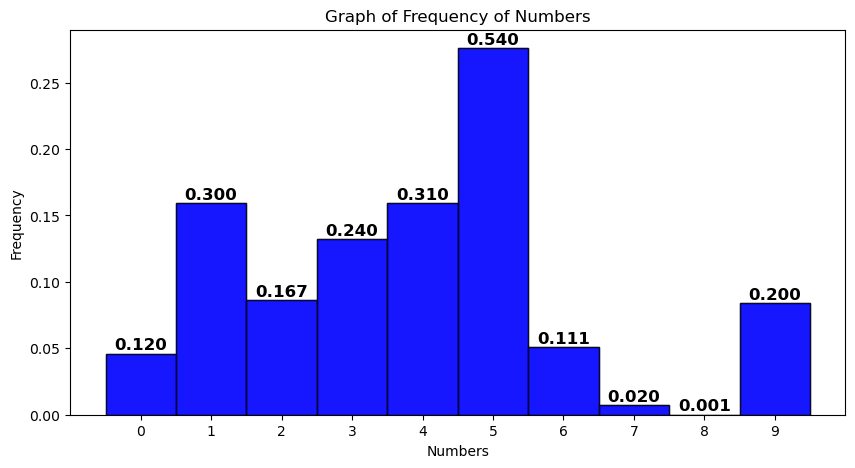

In [ ]:
numbers = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])

ind = np.argsort(-weights)
sorted_numbers, sorted_weights = numbers[ind], weights[ind]
sorted_weights /= sorted_weights.sum()

sample = np.random.choice(sorted_numbers, size=1000, p=sorted_weights)

plt.figure(figsize=(10, 5))
bars = plt.hist(sample, bins=np.arange(-0.5, 10.5, 1), density=True, alpha=0.7, color='blue', edgecolor='black')

bin_centers = (bars[1][:-1] + bars[1][1:]) / 2
bar_heights = bars[0]

for height, x, weight in zip(bar_heights, bin_centers, weights):
    plt.text(x, height + 0.003, f"{weight:.3f}", ha='center', fontsize=12, color='black', weight='bold')


plt.hist(sample, bins=np.arange(-0.5, 10.5, 1), density=True, alpha=0.7, color='blue', edgecolor='black')
plt.xticks(sorted_numbers)
plt.xlabel("Numbers")
plt.ylabel("Frequency")
plt.title("Graph of Frequency of Numbers")
plt.show()


## Inverse transform method

The following proposition is the idea behind the *inverse transform* method:

If $\xi$ has a uniform distribution in $[0,1]$, then $F^{-1}(\xi)$ is distributed according to the law of $F$. (For which $F$ is this true?)

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

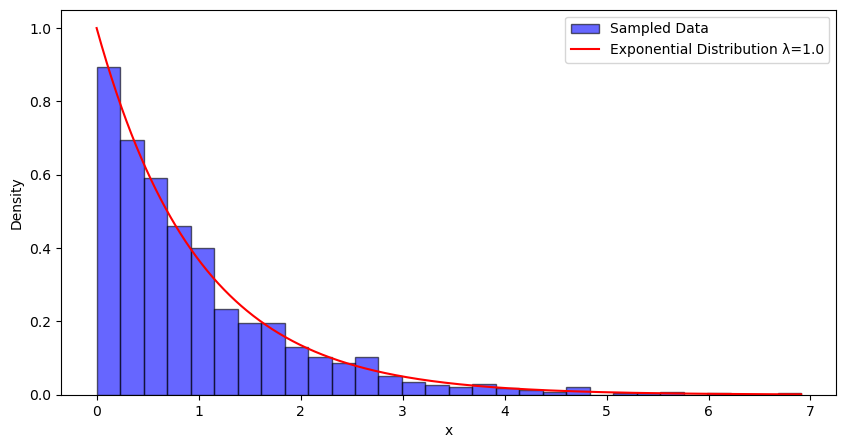

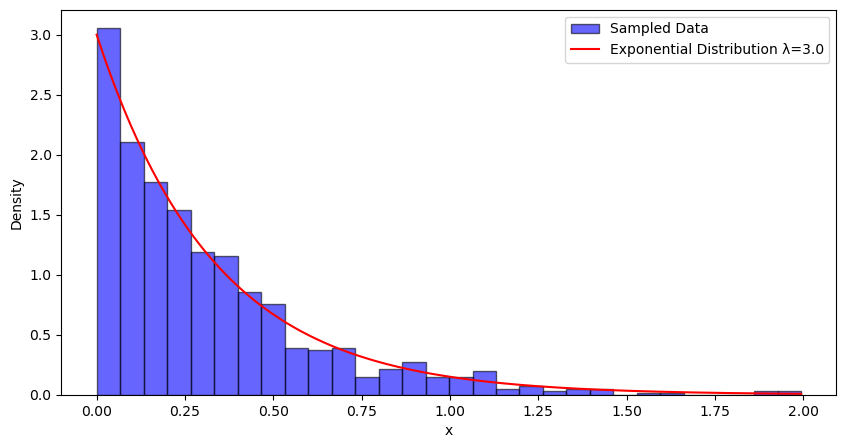

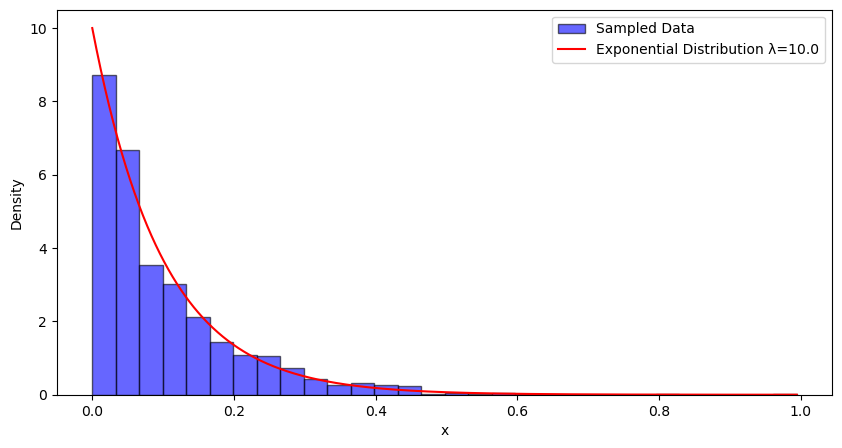

In [57]:
for lam in [1.0, 3.0, 10.0]:
    uni_samples = np.random.rand(1000)
    exp_samples = -np.log(uni_samples) / lam

    plt.figure(figsize=(10, 5))
    plt.hist(exp_samples, bins=30, density=True, alpha=0.6, color="blue", edgecolor="black", label="Sampled Data")

    x = np.linspace(0, max(exp_samples), 1000)
    pdf = lam * np.exp(-lam * x)

    plt.plot(x, pdf, 'r-', label=f"Exponential Distribution λ={lam}")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

## Rejection sampling (Accept-reject method)

The idea of the method is to sample from the distribution we know how to sample from, and then select points that follow the desired distribution. More precisely: let's say we know how to sample from a distribution with density $p$, and we want to sample from a distribution with density $\pi$. Let's take a random $x$ from the distribution $p$. Then take $y$ uniformly distributed on the interval $[0, p(x)]$. If the point $(x, y)$ falls under the graph of $\pi$, we take $x$ as a sampling element from $\pi$. If not, we repeat the procedure for a new $x$. The picture illustrates the idea of the method (the densities are normalised so that one lies entirely under the other):

<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>

## Coordinate transformation method

The accept-reject method may in some cases be inefficient and require too many sample points. An alternative is to try to find a coordinate transformation that converts a simple area (from which it is easy to sample, for example, a unit square) into the required area, but preserves the area ratio (why?).

### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

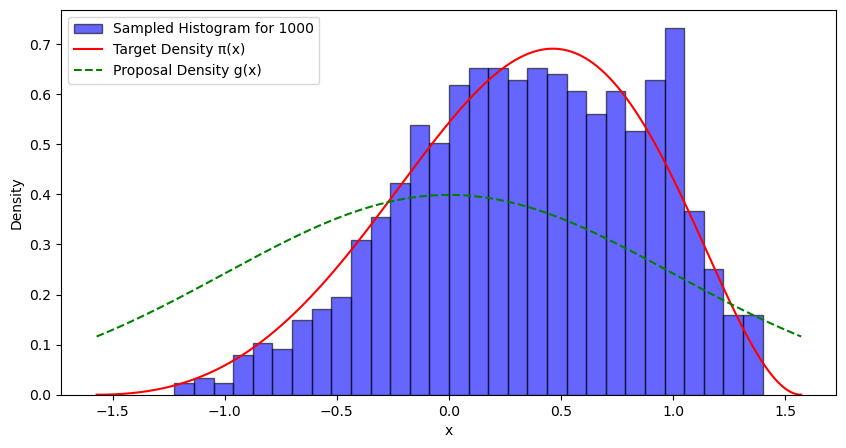

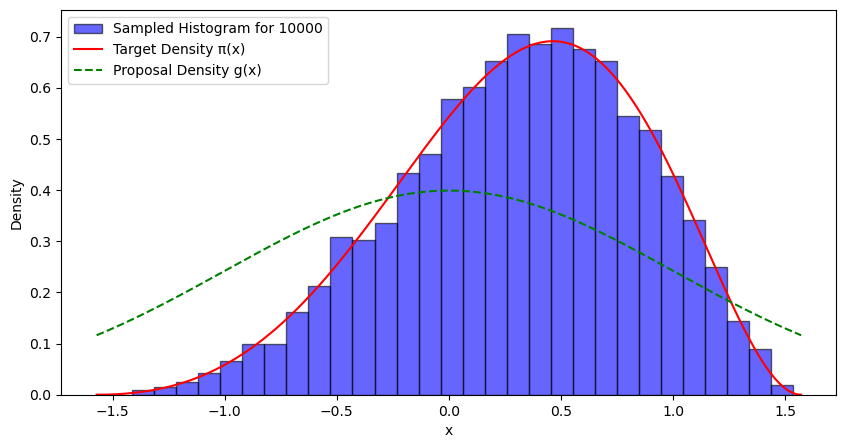

In [ ]:
def density(x):
    return np.exp(x) * np.cos(x) ** 2 * ((-np.pi / 2 <= x) & (x <= np.pi / 2))

sigma = 1.0
def proposal_distribution():
    return np.random.normal(loc=0, scale=sigma)

x_vals = np.linspace(-np.pi / 2, np.pi / 2, 1000)
M = max(density(x_vals) / (1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-x_vals**2 / (2 * sigma**2))))

def accept_reject_sampling(n):
    samples = []
    while len(samples) < n:
        x_star = proposal_distribution()
        u = np.random.uniform(0, 1)
        g_x_star = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-x_star**2 / (2 * sigma**2))
        if u < density(x_star) / (M * g_x_star):
            samples.append(x_star)
    return np.array(samples)

sampled_data = accept_reject_sampling(1000)
plt.figure(figsize=(10, 5))
plt.hist(sampled_data, bins=30, density=True, alpha=0.6, color="blue", edgecolor="black", label="Sampled Histogram for 1000")

x = np.linspace(-np.pi / 2, np.pi / 2, 1000)
plt.plot(x, density(x) / np.trapz(density(x), x), 'r-', label="Target Density π(x)")
plt.plot(x, (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-x**2 / (2 * sigma**2)), 'g--', label="Proposal Density g(x)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


sampled_data = accept_reject_sampling(10000)
plt.figure(figsize=(10, 5))
plt.hist(sampled_data, bins=30, density=True, alpha=0.6, color="blue", edgecolor="black", label="Sampled Histogram for 10000")

x = np.linspace(-np.pi / 2, np.pi / 2, 10000)
plt.plot(x, density(x) / np.trapz(density(x), x), 'r-', label="Target Density π(x)")
plt.plot(x, (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-x**2 / (2 * sigma**2)), 'g--', label="Proposal Density g(x)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()




## Coordinate transformation method

The accept-reject method may in some cases be inefficient and require too many sample points. An alternative is to try to find a coordinate transformation that converts a simple area (from which it is easy to sample, for example, a unit square) into the required area, but preserves the area ratio (why?).

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

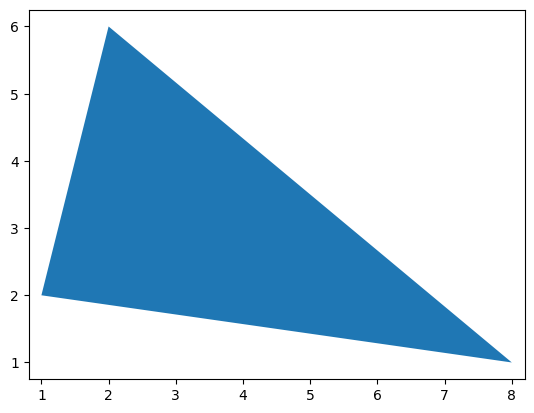

In [64]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig = plt.figure()

polygon = Polygon(xy=np.array([[1, 2], [2, 6], [8, 1]]), closed=True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.axis('equal')
plt.show()

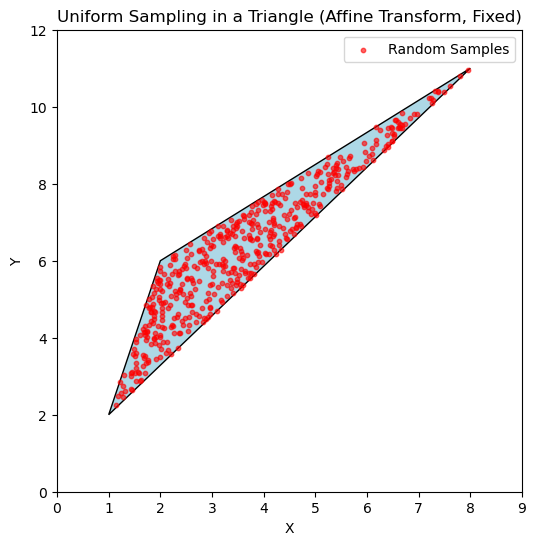

In [69]:
A = np.array([1, 2])
B = np.array([2, 6])
C = np.array([8, 11])

n = 500
U = np.sqrt(np.random.rand(n))
V = np.random.rand(n)

points = A + U[:, np.newaxis] * (B - A) + V[:, np.newaxis] * U[:, np.newaxis] * (C - B)

fig, fig2 = plt.subplots(figsize=(6, 6))

triangle = Polygon([A, B, C], closed=True, edgecolor='black', facecolor='lightblue')
fig2.add_patch(triangle)

fig2.scatter(points[:, 0], points[:, 1], color='red', alpha=0.6, s=10, label="Random Samples")
fig2.set_xlim(0, 9)
fig2.set_ylim(0, 12)
fig2.set_xlabel("X")
fig2.set_ylabel("Y")
fig2.set_title("Uniform Sampling in a Triangle (Affine Transform, Fixed)")
fig2.legend()
plt.show()



### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

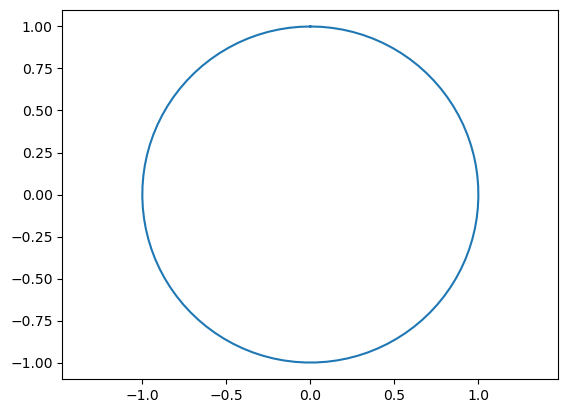

In [70]:
fig = plt.figure()

t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

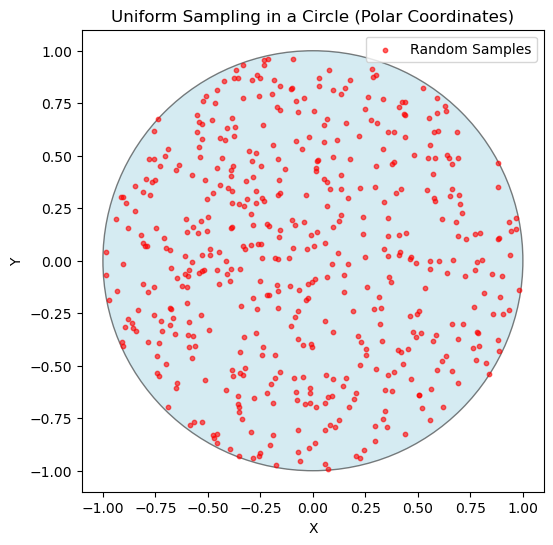

In [73]:
n = 500

theta = np.random.uniform(0, 2 * np.pi, n)
r = np.sqrt(np.random.uniform(0, 1, n))
x, y = r * np.cos(theta), r * np.sin(theta)

fig, fig2 = plt.subplots(figsize=(6,6))
circle = plt.Circle((0, 0), 1, facecolor='lightblue', alpha=0.5, edgecolor='black')

fig2.add_patch(circle)
fig2.scatter(x, y, color='red', alpha=0.6, s=10, label="Random Samples")
fig2.set_xlim(-1.1, 1.1)
fig2.set_ylim(-1.1, 1.1)
fig2.set_xlabel("X")
fig2.set_ylabel("Y")
fig2.set_title("Uniform Sampling in a Circle (Polar Coordinates)")
fig2.set_aspect('equal')
fig2.legend()
plt.show()

# Random normal generator

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

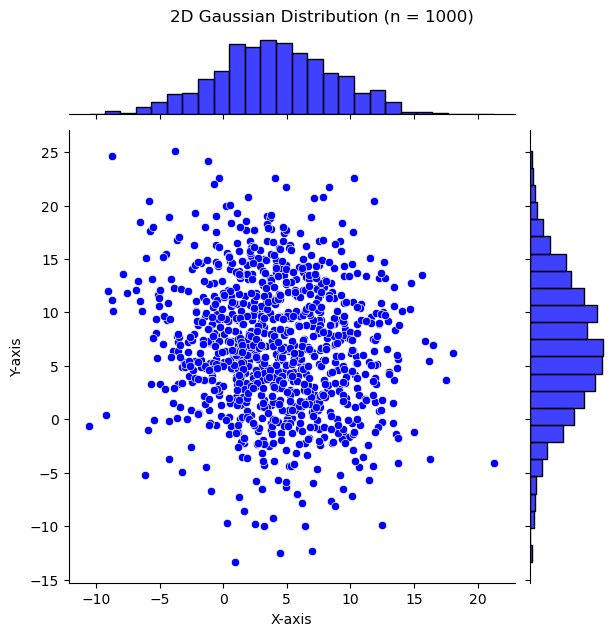

Полученное среднее: [4.069347522241114, 6.698808968394975]
Нужное среднее: [4, 7]


Полученная ковариация:
 [[22.12253487 -4.0086551 ]
 [-4.0086551  37.61527964]]
Нужная ковариация:
 [[20 -4]
 [-4 40]]


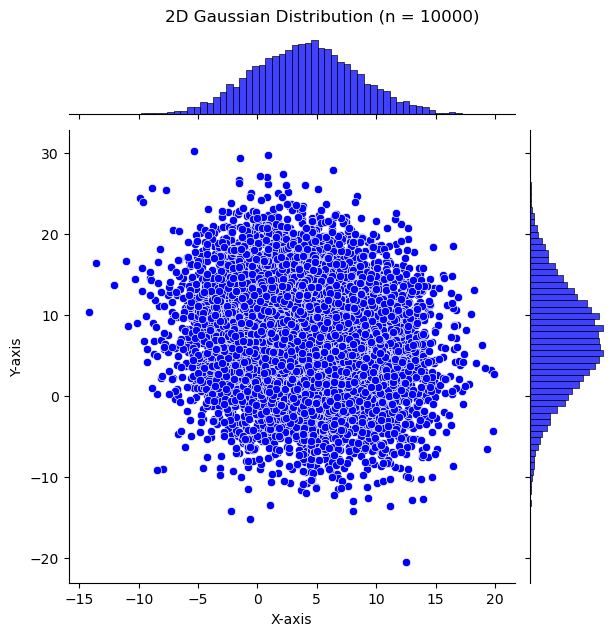

Полученное среднее: [4.0048134268240085, 6.928090624055872]
Нужное среднее: [4, 7]


Полученная ковариация:
 [[19.98218787 -3.83459669]
 [-3.83459669 38.67526153]]
Нужная ковариация:
 [[20 -4]
 [-4 40]]


In [89]:
import seaborn as sns

for n in [1000, 10000]:
    u1, u2 = np.random.rand(2, n)
    r, phi = np.sqrt(-2 * np.log(u1)), 2 * np.pi * u2
    x_std, y_std = r * np.cos(phi), r * np.sin(phi)

    Sigma = np.array([
        [20, -4],
        [-4, 40]
    ])

    XY_std = np.vstack([x_std, y_std])
    XY_cov = np.linalg.cholesky(Sigma) @ XY_std

    x_tr, y_tr = 4 + XY_cov[0, :], 7 + XY_cov[1, :]

    joint_plot = sns.jointplot(x=x_tr, y=y_tr, color="blue")
    joint_plot.set_axis_labels('X-axis', 'Y-axis')
    plt.suptitle(f'2D Gaussian Distribution (n = {n})', y=1.02)
    plt.show()

    print("Полученное среднее:", [np.mean(x_tr), np.mean(y_tr)])
    print("Нужное среднее: [4, 7]\n\n")
    print("Полученная ковариация:\n", np.cov(x_tr, y_tr))
    print("Нужная ковариация:\n", Sigma)
